In [1]:
import string
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from numpy.random import exponential, normal

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
gg.theme_set(gg.theme_minimal())

In [4]:
RANDOM_SEED = 103

---

## Model 3. Multiple logFC readings per gene per cell line and only one RNA expression reading

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
There are multiple logFC readings per gene per cell line, but only one RNA expression reading.
(For now) there is only one varying effect for gene.

$
logFC_g \sim \mathcal{N}(\mu_g, \sigma) \\
\quad \mu_g = \alpha_g \\
\qquad \alpha_g \sim \mathcal{N}(\mu_{\alpha_g}, \sigma_{\alpha_g}) \\
\qquad \quad \mu_{\alpha_g} = \gamma_g + \delta_g R \\
\qquad \qquad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \qquad \quad \mu_\gamma \sim \mathcal{N}(0,5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \qquad \delta_g \sim \mathcal{N}(\mu_\delta, \sigma_\delta) \\
\qquad \qquad \quad \mu_\delta \sim \mathcal{N}(0,5) \quad \sigma_\delta \sim \text{Exp}(1) \\
\qquad \quad \sigma_{\alpha_g} \sim \text{Exp}(\sigma_g) \\
\qquad \qquad \sigma_g \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$

Simulated real values:

- number of cell lines: 30
- number of logFC data points per gene per cell line: 3
- number of genes: 5
- $\mu_\gamma = -1$
- $\sigma_\gamma = 0.4$
- $\mu_\delta = 0$
- $\sigma_\delta = 1$
- $\sigma_g = 0.4$
- $\sigma = 0.3$

In [5]:
np.random.seed(RANDOM_SEED)

# Synthetic data parmeters
num_cell_lines = 20
num_logfc_datum = 3
num_genes = 5

# Real hyper-parameter values
real_mu_gamma = -1
real_sigma_gamma = 0.4
real_mu_delta = 0
real_sigma_delta = 1
real_sigma_g = 0.4
real_sigma = 0.3


genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
gene_idx = list(range(num_genes))

cell_lines = ["cell" + a for a in string.ascii_uppercase[:num_cell_lines]]
cell_line_idx = list(range(num_cell_lines))

# RNA expression data (scaled within each gene)
rna = np.random.normal(loc=0, scale=1, size=(num_genes, num_cell_lines))
rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])
rna_data["rna"] = rna.flatten()

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])


real_gamma_g = np.random.normal(real_mu_gamma, real_sigma_gamma, (num_genes, 1))
real_delta_g = np.random.normal(real_mu_delta, real_sigma_delta, (num_genes, 1))
real_mu_alpha = (real_gamma_g + rna * real_delta_g).mean(axis=1)
real_sigma_alpha = np.random.exponential(real_sigma_g, num_genes)

real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha)
real_mu_g = real_alpha_g

ko_idx = list(range(num_logfc_datum))
logfc_data = pd.DataFrame(
    list(product(ko_idx, genes, cell_lines)), columns=["ko_idx", "gene", "cell_line"]
)

for c in ["gene", "cell_line"]:
    logfc_data[c] = pd.Categorical(logfc_data[c])


logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    g = logfc_data["gene"].cat.codes[i]
    logfc_data.loc[i, "logfc"] = np.random.normal(real_mu_g[g], real_sigma)

logfc_data

,ko_idx,gene,cell_line,logfc
0,0,geneA,cellA,-1.475160
1,0,geneA,cellB,-1.574389
2,0,geneA,cellC,-1.413401
3,0,geneA,cellD,-1.057404
4,0,geneA,cellE,-1.570743
...,...,...,...,...
295,2,geneE,cellP,0.758133
296,2,geneE,cellQ,0.352038
297,2,geneE,cellR,0.583303
298,2,geneE,cellS,0.818320


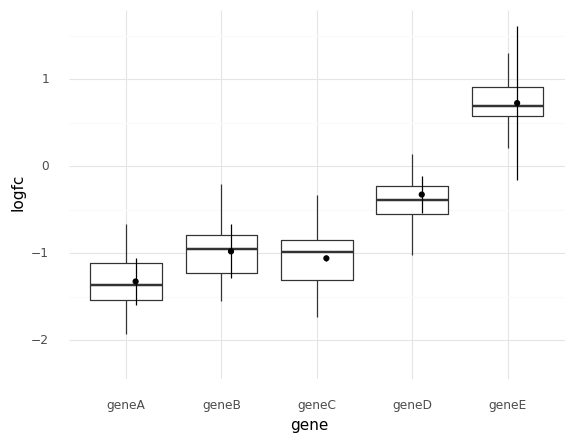

<ggplot: (8737775755237)>

In [6]:
known_logfc_values_df = pd.DataFrame(
    {"gene": genes, "logfc": real_alpha_g, "sd": real_sigma_alpha}
)
known_logfc_values_df["lower_err"] = (
    known_logfc_values_df["logfc"] - known_logfc_values_df["sd"]
)
known_logfc_values_df["upper_err"] = (
    known_logfc_values_df["logfc"] + known_logfc_values_df["sd"]
)

pos = gg.position_nudge(x=0.1)

(
    gg.ggplot(logfc_data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_linerange(
        gg.aes(ymin="lower_err", ymax="upper_err"),
        data=known_logfc_values_df,
        position=pos,
    )
    + gg.geom_point(data=known_logfc_values_df, position=pos)
)

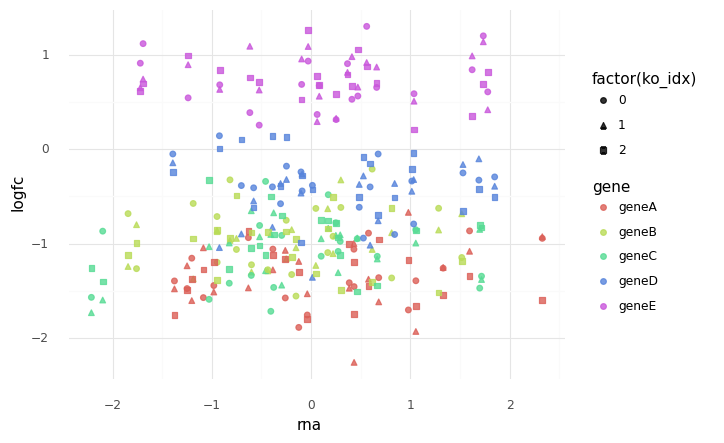

<ggplot: (8737725598501)>

In [7]:
merged_data = pd.merge(logfc_data, rna_data, how="inner", on=["gene", "cell_line"])

(
    gg.ggplot(merged_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(gg.aes(shape="factor(ko_idx)"), alpha=0.8, size=1.8)
)

### Conclusions and final thoughts

This was an incorrect understanding of how to use a predictor variable in a higher level of the model.
Though it is not the right model the purposes of this project, I'll leave it here as an example.

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

seaborn  0.11.0
numpy    1.19.2
pandas   1.1.3
pymc3    3.9.3
arviz    0.10.0
plotnine 0.7.1
last updated: 2020-10-26 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-237.o2.rc.hms.harvard.edu
Git branch : models
